# Adaptive PDE discretizations on cartesian grids 
## Volume : Algorithmic tools
## Part : Automatic differentiation
## Chapter : Known bugs and incompatibilities

The techniques of automatic differentiation technique play an essential role in the notebooks presented in this repository. 

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1 Matrix multiplication and inversion](#1-Matrix-multiplication-and-inversion)
  * [2. In place modifications and aliasing](#2.-In-place-modifications-and-aliasing)
    * [2.1 Aliasing of the AD information](#2.1-Aliasing-of-the-AD-information)
    * [2.2 Non writeable AD information](#2.2-Non-writeable-AD-information)
  * [3. CPU/GPU generic programming](#3.-CPU/GPU-generic-programming)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow importing agd from parent directory
#from Miscellaneous import TocTools; TocTools.displayTOC('ADBugs','Algo')

In [2]:
import numpy as np
import scipy.sparse.linalg
from matplotlib import pyplot as plt

In [3]:
import agd.AutomaticDifferentiation as ad

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad
    ad, = rreload([ad],rootdir='..',verbose=True)

## 1 Matrix multiplication and inversion

Please use the `ad.apply_linear_mapping` and `ad.apply_linear_inverse` functions in combination with `np.dot`, or scipy solve functions.

In [5]:
v = ad.Dense.denseAD( np.random.standard_normal((4,)),np.random.standard_normal((4,4)))
m0 = np.random.standard_normal((4,4))
m1 = scipy.sparse.coo_matrix( ([1.,2.,3.,4.,5.],([0,2,1,2,3],[0,1,2,2,3]))).tocsr()

In [6]:
# Fails
#print("np.dot looses AD:",np.dot(m0,v))
#print("scipy '*' looses AD:",m1*v) 

In [7]:
print("np.dot with AD:\n",ad.apply_linear_mapping(m0,v))
print("scipy '*' with AD:\n",ad.apply_linear_mapping(m1,v))

np.dot with AD:
 denseAD([ 1.75517179 -1.69629535 -0.51405702 -2.4679181 ],
[[-0.99814527 -2.56818975 -0.49318764  1.22457235]
 [-1.4015223   1.58409978  0.07744961 -1.3644251 ]
 [-1.69064348  0.88884647 -0.81304779 -1.13829961]
 [-1.23754601  1.08858405  0.641416   -1.09759751]])
scipy '*' with AD:
 denseAD([-0.20030751 -2.21465588 -5.50238097  5.40827971],
[[ 0.23072388  1.18182741 -0.5646482  -0.74529293]
 [ 6.12594207  3.10121378  6.27002047  1.4959306 ]
 [ 4.70837682  6.14603459  7.5202877  -0.49226696]
 [-4.87556635 -0.63022697 -6.91560923 -1.81057886]])


In [8]:
print("scipy solve with AD :\n",ad.apply_linear_inverse(scipy.sparse.linalg.spsolve,m1,v))

scipy solve with AD :
 denseAD([-0.20030751  0.48072618 -0.42491774  0.21633119],
[[ 0.23072388  1.18182741 -0.5646482  -0.74529293]
 [ 2.17417232 -0.153492    1.32491661  1.0782688 ]
 [-0.57659099  0.33518048 -0.1399566  -0.41447352]
 [-0.19502265 -0.02520908 -0.27662437 -0.07242315]])


## 2. In place modifications and aliasing

The AD information often consists of very large arrays. In order to save time and memory, this information is not systematically copied and/or stored fully. It can take the form of a broadcasted array, or of an alias to another array. In that case a copy is necessary to enable modifications.

### 2.1 Aliasing of the AD information

When an operation leaves the AD information untouched, an alias is used. This can lead to bugs if in place modifications are used afterward.

In [9]:
x=ad.Dense.identity(constant=np.array([1.,2.]))
y=x+1 # Only affects the value, not the AD information

In [10]:
print("Values are distinct :", x.value is y.value)
print("AD information is shared :", y.coef is x.coef)

Values are distinct : False
AD information is shared : True


A modification of the aliased variable will impact the original one.

In [11]:
print(x[0])
y[0]*=2
print("Caution ! Shared AD information is affected :", x[0])

denseAD(1.0,[1. 0.])
Caution ! Shared AD information is affected : denseAD(1.0,[2. 0.])


Avoid this effect by making a copy.

In [12]:
x=ad.Dense.identity(constant=np.array([1.,2.]))
y=(x+1).copy()
print("AD information is distinct :", y.coef is x.coef)

AD information is distinct : False


Note that a similar effect arises with the `-` binary operator, but not with `*`or `/`. That is because the latter modify the AD information, which therefore must be copied anyway.

In [13]:
x=ad.Dense.identity(constant=np.array([1.,2.]))
print("AD information is shared :", (x-1).coef is x.coef)
print("AD information is distinct :", (x*2).coef is x.coef)
print("AD information is distinct :", (x/2).coef is x.coef)

AD information is shared : True
AD information is distinct : False
AD information is distinct : False


### 2.2 Non writeable AD information

When creating an dense AD variable, the coefficients may be non writeable (e.g. broadcasted) arrays.

In [14]:
x=ad.Dense.identity(constant=np.array([[1.,2.],[3.,4.]]),shape_bound=(2,))

In [15]:
x.coef.flags.writeable

False

In [16]:
# x+=1 # Fails because non-writeable

Make a copy to solve the issue.

In [17]:
y=x.copy()

In [18]:
y.coef.flags.writeable

True

In [19]:
y+=1

## 3. CPU/GPU generic programming

The agd library allows CPU/GPU generic programming to some extent. Here are the guidelines to make this approach work.

*Make a copy of the numpy array module*

In [20]:
xp = np 

*Activate GPU acceleration.*
If uncommented, the following line will replace the module xp with np, and modify its other arguments in a custom manner intended for easy interaction.

In [21]:
#xp,plt = map(ad.cupy_friendly,[xp,plt])

*Create basic arrays using `xp`.* Basic arrays are arrays of zeros, of ones, arange, linspace, etc

In [22]:
x = xp.linspace(0,2*np.pi)

*Use numpy's overloading mechanisms.* These mechanisms will dispatch the function calls to cupy, or to the AutomaticDifferentiation module of the agd library, depending on the data type (array from numpy, cupy, or ad).

In [23]:
y = np.sin(x)

*Use `ad.asarray` and `ad.array`.* Stacking arrays using np.array will not work for AD or cupy arrays.

In [24]:
xy = ad.array([x,y])

*Use functions that accept both numpy and cupy arrays.* Or modify them for that purpose, as we did for the member functions of the pyplot module using the `ad.cupy_friendly` function.

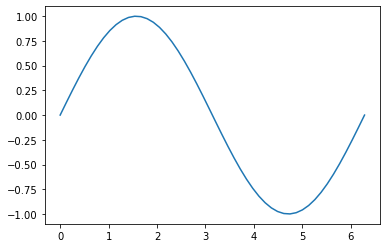

In [25]:
plt.plot(*xy);

*If needed, convert cupy array's to numpy arrays.* Using the `get` member function of the `cupy.ndarray` class, or using `ad.cupy_generic.cupy_get` (which leaves non-cupy variables unchanged).

In [26]:
type(ad.cupy_generic.cupy_get(y))

numpy.ndarray